In [1]:
import os 
import numpy as np 
import pickle
from matplotlib import pyplot as plt
import matplotlib
import shutil
# import seaborn as sns
# from traj_run import rho_ohmic
from typing import Any
from numpy import dtype, ndarray
import scipy
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import pywt
from data_analysis import read_line, read_exp, read_omega, get_rho_array, translate_param, chunk_data, interp_dat, do_fft, \
    fft_analysis, func_gentor, draw_t_S, draw_w_S, wavelet_denoising, line_monotonic_detect, show_result_t_S, \
    show_fft_res, show_w_freqs, show_w_freqs1, get_data_of_dof, get_signal_freq, do_cft, get_signal_amp, read_job_parameter, \
    amp_func, freq_func, fit_amp_singnal, fit_freq_singnal

from scipy.optimize import curve_fit

2024-12-02 14:49:48,007[INFO] Use NumPy as backend
2024-12-02 14:49:48,008[INFO] numpy random seed is 9012
2024-12-02 14:49:48,008[INFO] random seed is 1092
2024-12-02 14:49:48,010[INFO] Git Commit Hash: bd1de1a1b0b4b2d05d9e15eba47bce21216944dc
2024-12-02 14:49:48,010[INFO] use 64 bits


In [2]:

mother_folder = '/home/ansatz/data/comp/sbm/24_09_28'
nsteps = 500

In [3]:
vn_entropy_1site_all_lines ={}
# for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
#     points = { i_step : f"_{i_step}_step_entropy_1sites.pickle" for i_step in range(100) }
#     nmodes = int(os.path.basename(line).split('_nmodes')[1].split('_')[0])

#     rho_type = 0 if 'rho_type' not in os.path.basename(line) else int(os.path.basename(line).split('rho_type_')[1])    
#     key = f"{line.split('_')[1]}-{line.split('_')[2]}-nmodes{nmodes}-rho{rho_type}"
#     print(key)
#     vn_entropy_1site_all_lines[key] = points
print('-----')
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    key = line

    vn_entropy_1site_all_lines[key] = points

-----


In [4]:
for key in vn_entropy_1site_all_lines.keys():
    print(key)

traj_s0.10_alpha0.01_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.15_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.30_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho

In [5]:
def get_freq_cft_xf_yf(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines,\
                  s=0.7, alpha=0.4, nmodes=1000, rho_type=0, nsteps=100,
                  idof=504):
    v_dof = data = get_data_of_dof(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines,\
                  s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps,
                  idof=idof)
    signal = wavelet_denoising(v_dof)
    N = 1001
    xf, yf = do_cft(np.linspace(0, 10, 100), signal, N)

    plt.clf()

    
    amp = 2.0/N * np.abs(yf)

    plt.title(f's_{s}-alpha_{alpha}-nmodes_{nmodes}-rho_type_{rho_type}-nsteps_{nsteps}')
    plt.plot(xf, amp, label=f'v_{idof}')
    indexs , _ = scipy.signal.find_peaks(amp)
    
    if len(indexs) != 0 : 
        peaks = [ amp[index] for index in indexs ]
        freqs = [ xf[index] for index in indexs ]
        with open(f'data/s{s}-alpha{alpha}-idof_{idof:03}_cft_peaks.pickle', 'wb') as f:
            pickle.dump([freqs, peaks], f)
        # index = indexs[peaks.index(max(peaks))]
        # index = indexs[0]
        # print(peaks.index(max(peaks)), index)
        # index = indexs[0]
        # freq =  xf[index]
        # amplitude = amp[index]
        # amplitude = 2.0/N * np.abs(yf[index])
        # phase = np.angle(np.abs(yf[index]))
        # print(freq, amplitude)
        sorted_peaks = sorted(peaks, reverse=True)
        index = indexs[peaks.index(sorted_peaks[0])]
        freq =  xf[index]
        amplitude = amp[index]
        plt.scatter(freq, amplitude, color='red')
        plt.annotate(text=f'{xf[index]}_{amp[index]}', xy=(xf[index], amp[index]), xytext=(xf[index], amp[index]))
        if len(indexs) >= 1:
            index = indexs[peaks.index(sorted_peaks[1])]
            freq =  xf[index]
            amplitude = amp[index]
            plt.scatter(freq, amplitude, color='red')
            plt.annotate(text=f'{xf[index]}_{amp[index]}', xy=(xf[index], amp[index]), xytext=(xf[index], amp[index]))

        if len(indexs) >= 2:
            index = indexs[peaks.index(sorted_peaks[2])]
            freq =  xf[index]
            amplitude = amp[index]
            plt.scatter(freq, amplitude, color='red')
            plt.annotate(text=f'{xf[index]}_{amp[index]}', xy=(xf[index], amp[index]), xytext=(xf[index], amp[index]))
        plt.legend()
        plt.savefig(f'data/s{s}-alpha{alpha}-idof_{idof:03}_cft_peaks.png')
        # plt.clf()
        return freq
    else:
        return 0


def r_squared(x,y, param_list, func):
    mean = np.mean(y)  # 1.y mean

    ss_tot = np.sum((y - mean) ** 2)  # 2.total sum of squares

    ss_res = np.sum((y - func(x, *param_list)) ** 2)  # 3.residual sum of squares

    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [6]:
ids = [ i for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]


In [7]:
bond_dims

20

In [8]:
s=0.5
alpha=0.80
nmodes=1000
rho_type=0
nstep=500   
Omega=1
omega_c=10
td_method=0
bond_dims=20


job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

key =job_name

omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key, nstep=nstep)

In [9]:
dats = [get_signal_freq(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]

In [10]:
y_true = np.array([ _[1] for _ in dats ])
x = np.array([ _[0] for _ in dats ])
a, b = fit_freq_singnal(dats)
r_2 = r_squared(x, y_true, [a, b], freq_func)

Text(0.1, 0.1, 'y = 0.158911 * x + -0.000183, R**2: 1.000')

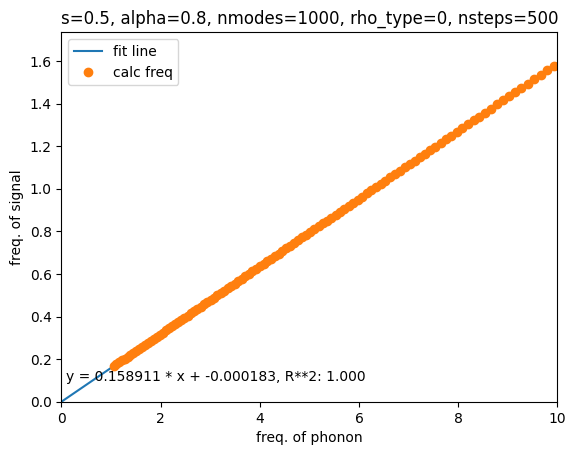

In [11]:
func_x = np.linspace(0, 10, 500)
func_y = a * func_x + b
plt.plot(func_x, func_y , label='fit line')
plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ],'o', label='calc freq')
plt.xlim(0, 10)
plt.xlabel('freq. of phonon')
plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
plt.ylabel('freq. of signal')
plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
plt.legend()
plt.text(x=0.1, y=0.1, s=f'y = {a:3f} * x + {b:3f}, R**2: {r_2:.3f}')

In [12]:
dats = [ get_signal_amp(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630 ]

In [13]:
y_true = np.array([ _[1] for _ in dats ])
x = np.array([ _[0] for _ in dats ])
a, b, c = fit_amp_singnal(dats)


Text(0.1, 0.1, 'y = 2.006 * exp(-0.969*x) + 0.025 ')

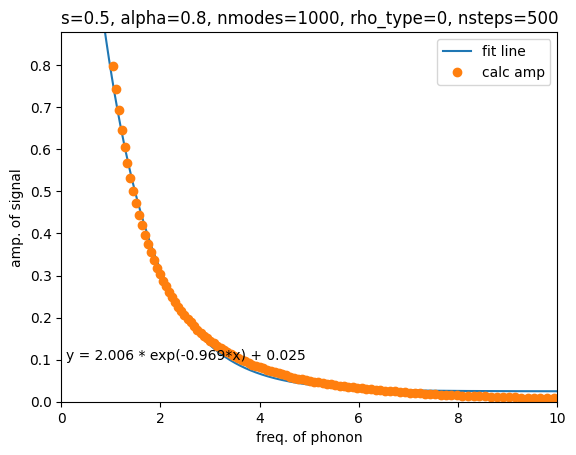

In [14]:
func_x = np.linspace(0, 10, 500)
func_y = amp_func(func_x, a, b, c)
plt.plot(func_x, func_y , label='fit line')
plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ],'o', label='calc amp')
plt.xlim(0, 10)
plt.xlabel('freq. of phonon')


plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
plt.ylabel('amp. of signal')
plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
plt.legend()

plt.text(x=0.1, y=0.1, s=f'y = {a:.3f} * exp({b:.3f}*x) + {c:.3f} ')

In [15]:
dats[0][2]

[0.7988588732587405,
 0.7991532374744574,
 0.7991466118677165,
 0.7993376890658326,
 0.7989901369210167,
 0.7988778526852707,
 0.7987541380607455]

In [16]:
np.std(np.array(dats[0][2]))

0.00018988169171758673

In [82]:
def draw_freq_plot_withfit(s, alpha, mother_folder, data_dict, plot=False ):
    # s=0.5
    # alpha=0.80
    nmodes=1000
    rho_type=0
    nstep=500   
    Omega=1
    omega_c=10
    td_method=0
    bond_dims=20


    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    key =job_name

    omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, data_dict, key, nstep=nstep)
    
    dats = [ get_signal_freq(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630 ]    
    y_true = np.array([ _[1] for _ in dats ])
    x = np.array([ _[0] for _ in dats ])

    a, b = fit_freq_singnal(dats)
    r_2 = r_squared(x, y_true, [a, b], freq_func)

    if plot:
        func_x = np.linspace(0, 10, 500)
        func_y = a * func_x + b
        plt.plot(func_x, func_y , label=f's{s:.02f}-alpha{alpha:.02f}_fit line')
        plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ],'o', label=f's{s:.02f}-alpha{alpha:.02f}_calc freq')
        plt.xlim(0, 10)
        plt.xlabel('freq. of phonon')
        plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
        plt.ylabel('freq. of signal')
        plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
        # plt.legend(draggable=True)
        # plt.text(x=0.1, y=0.1, s=f'y = {a:3f} * x + {b:3f}, R**2: {r_2:.3f}')
    return (a, b, r_2)

In [83]:
def draw_amp_plot_withfit(s, alpha, mother_folder, data_dict , plot=False):
    # s=0.5
    # alpha=0.80
    nmodes=1000
    rho_type=0
    nstep=500   
    Omega=1
    omega_c=10
    td_method=0
    bond_dims=20


    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    key =job_name

    omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, data_dict, key, nstep=nstep)
    dats = [get_signal_amp(mother_folder=mother_folder, data_dict=data_dict, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]
    y_true = np.array([ _[1] for _ in dats ])
    x = np.array([ _[0] for _ in dats ])

    a, b, c = fit_amp_singnal(dats)

    if plot:
        func_x = np.linspace(0, 10, 500)
        func_y = amp_func(func_x, a, b, c)
        plt.plot(func_x, func_y , label=f's{s:.02f}-alpha{alpha:.02f}_fit line')
        plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ],'o', label=f's{s:.02f}-alpha{alpha:.02f}_calc amp')
        plt.xlim(0, 10)
        plt.xlabel('freq. of phonon')
    
    
        plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
        plt.ylabel('amp. of signal')
        plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
        # plt.legend(draggable=True)
    
        # plt.text(x=0.1, y=0.1, s=f'y = {a:.3f} * exp({b:.3f}*x) + {c:.3f} ')
    return (a, b, c)

In [19]:
draw_freq_plot_withfit(0.5, 0.8, mother_folder, vn_entropy_1site_all_lines)

(0.15891143562468144, -0.00018305651493603586, 0.9999999508424297)

In [20]:
with open('incoherent_points.pickle', 'rb') as f:
    incoherent_points = pickle.load(f)

with open('pseudo_coherent_points.pickle', 'rb') as f:
    pseudo_coherent_points = pickle.load(f)

with open('coherent_points.pickle', 'rb') as f:
    coherent_points = pickle.load(f)

In [21]:
incoherent_points

[(0.55, 0.2),
 (0.6, 0.2),
 (0.6, 0.25),
 (0.65, 0.2),
 (0.65, 0.25),
 (0.65, 0.3),
 (0.7, 0.2),
 (0.7, 0.25),
 (0.7, 0.3),
 (0.7, 0.35),
 (0.7, 0.4),
 (0.7, 0.45),
 (0.75, 0.25),
 (0.75, 0.3),
 (0.75, 0.35),
 (0.75, 0.4),
 (0.75, 0.45),
 (0.75, 0.5),
 (0.75, 0.6),
 (0.8, 0.25),
 (0.8, 0.3),
 (0.8, 0.35),
 (0.8, 0.4),
 (0.8, 0.45),
 (0.8, 0.5),
 (0.8, 0.55),
 (0.8, 0.6),
 (0.8, 0.65),
 (0.8, 0.7),
 (0.8, 0.75),
 (0.8, 0.8),
 (0.8, 0.85),
 (0.8, 0.9),
 (0.85, 0.3),
 (0.85, 0.35),
 (0.85, 0.4),
 (0.85, 0.45),
 (0.85, 0.5),
 (0.85, 0.55),
 (0.85, 0.6),
 (0.85, 0.65),
 (0.85, 0.7),
 (0.85, 0.75),
 (0.85, 0.8),
 (0.85, 0.85),
 (0.85, 0.9),
 (0.85, 0.95),
 (0.9, 0.35),
 (0.9, 0.4),
 (0.9, 0.45),
 (0.9, 0.5),
 (0.9, 0.55),
 (0.9, 0.6),
 (0.9, 0.65),
 (0.9, 0.7),
 (0.9, 0.75),
 (0.9, 0.8),
 (0.9, 0.85),
 (0.9, 0.9),
 (0.9, 0.95),
 (0.95, 0.4),
 (0.95, 0.45),
 (0.95, 0.5),
 (0.95, 0.55),
 (0.95, 0.6),
 (0.95, 0.65),
 (0.95, 0.7),
 (0.95, 0.75),
 (0.95, 0.8),
 (0.95, 0.85),
 (0.95, 0.9),
 (0.95,

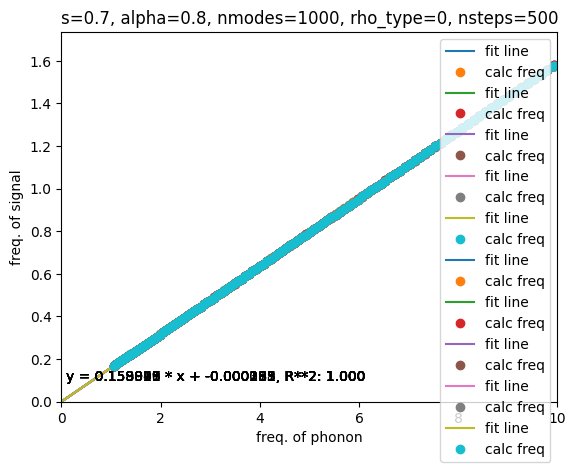

In [22]:
pseudo_coherent_points_freq_fit_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in pseudo_coherent_points:
        parms = draw_freq_plot_withfit(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)
        a = parms[0]
        b = parms[1]
        r_2 = parms[2]
        key = line  

        pseudo_coherent_points_freq_fit_results[key] = (a, b)

In [23]:
pseudo_coherent_points_freq_fit_results

{'traj_s0.10_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15907908313386213,
  -0.00033831726998253983),
 'traj_s0.10_alpha0.15_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15902916544954362,
  -0.00028528396301843155),
 'traj_s0.10_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15899778433019673,
  -0.0002770064659655965),
 'traj_s0.30_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15889718804958694,
  -0.00016068491349512288),
 'traj_s0.40_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.159039955939008,
  -8.485289895827938e-05),
 'traj_s0.40_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15901495144814573,
  -9.54009358094046e-05),
 'traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15899310555409762,
  -0.0001112820281699856),
 'traj_s0.40_alpha0.80_Omega1_omega_c10_n

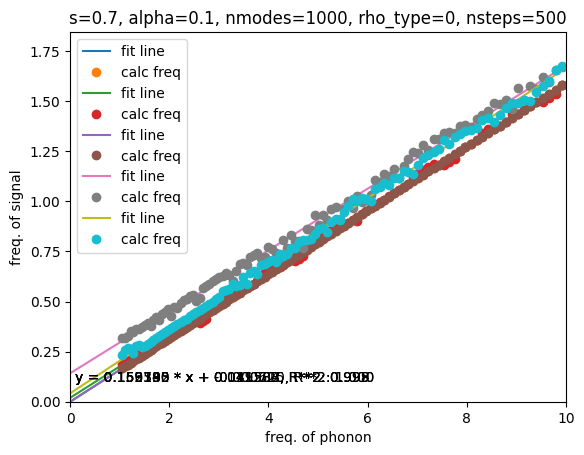

In [24]:
coherent_points_freq_fit_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in coherent_points:
        parms = draw_freq_plot_withfit(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)
        a = parms[0]
        b = parms[1]
        r_2 = parms[2]
        key = line  

        coherent_points_freq_fit_results[key] = (a, b)

In [25]:
coherent_points_freq_fit_results

{'traj_s0.10_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15919485745521222,
  -0.0007249671075995289),
 'traj_s0.40_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15673295748670338,
  0.019207988451829222),
 'traj_s0.40_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15918002039173057,
  -0.0006096643720233943),
 'traj_s0.70_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15353954196405292,
  0.14158665063984985),
 'traj_s0.70_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.16239165219917892,
  0.041534218253721084)}

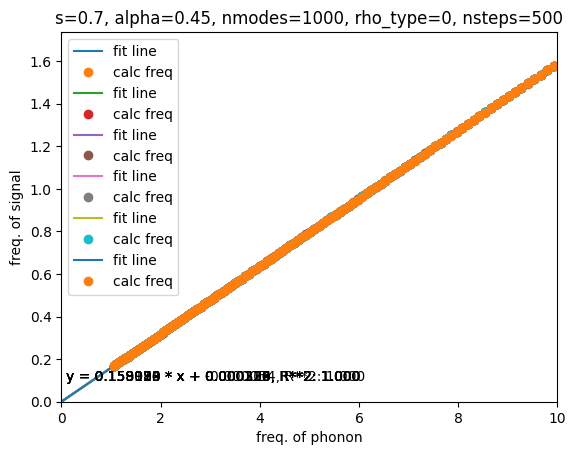

In [26]:
incoherent_points_freq_fit_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in incoherent_points:
        parms = draw_freq_plot_withfit(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)
        a = parms[0]
        b = parms[1]
        r_2 = parms[2]
        key = line  

        incoherent_points_freq_fit_results[key] = (a, b)


In [27]:
incoherent_points_freq_fit_results

{'traj_s0.70_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15911335322515144,
  -5.4196320329597816e-05),
 'traj_s0.70_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.1590730910370883,
  0.00012271124806326433),
 'traj_s0.70_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.1590197786830288,
  0.00033042213208895574),
 'traj_s0.70_alpha0.35_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15899902600747043,
  0.00033555949431644393),
 'traj_s0.70_alpha0.40_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15898391210600327,
  0.0003043745131463751),
 'traj_s0.70_alpha0.45_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.1589797116672486,
  0.00021869290038642052)}

## AMP


In [ ]:

pseudo_coherent_points_amp_degree_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    key =job_name
    if (s, alpha) in pseudo_coherent_points:
        omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key, nstep=nstep)
        dats = [get_signal_amp(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]
        buffer = []
        buffer.append([])
        buffer.append([])
        for i in range(dats.__len__()):

            amp_std = np.std(np.array(dats[i][2]))
            amp_mean = np.mean(np.array(dats[i][2]))
            amp_var = np.var(np.array(dats[i][2]))

            degree = amp_var/amp_mean # how fat it is 
            buffer[0].append(amp_var)
            buffer[1].append(degree)
        pseudo_coherent_points_amp_degree_results[key] = buffer


    

In [50]:
for key in pseudo_coherent_points_amp_degree_results:
    value = pseudo_coherent_points_amp_degree_results[key]
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    print(f's{s:.02f}-alpha{alpha:.02f},', f'{max(value[0]):.04f},', f'{max(value[1]):.04f}')

s0.10-alpha0.10, 0.0061, 0.0042
s0.10-alpha0.15, 0.0039, 0.0024
s0.10-alpha0.20, 0.0000, 0.0000
s0.30-alpha0.80, 0.0000, 0.0000
s0.40-alpha0.20, 0.0040, 0.0033
s0.40-alpha0.25, 0.0024, 0.0020
s0.40-alpha0.30, 0.0000, 0.0000
s0.40-alpha0.80, 0.0000, 0.0000
s0.50-alpha0.80, 0.0000, 0.0000
s0.70-alpha0.80, 0.0000, 0.0000


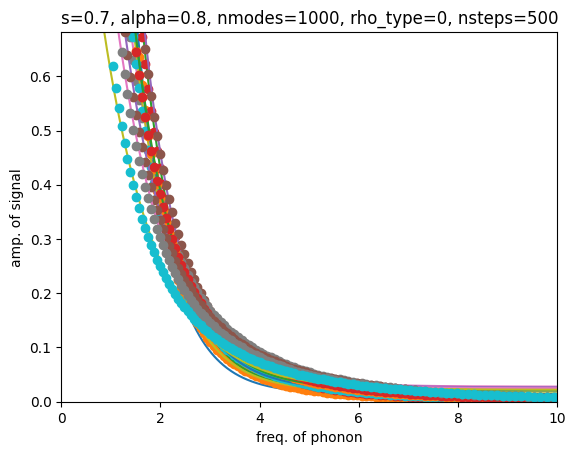

In [84]:
pseudo_coherent_points_amp_fit_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in pseudo_coherent_points:
        parms = draw_amp_plot_withfit(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)
        a = parms[0]
        b = parms[1]
        c = parms[2]
        key = line  

        pseudo_coherent_points_amp_fit_results[key] = (a, b, c)



In [71]:
for key in pseudo_coherent_points_amp_fit_results:
    value = pseudo_coherent_points_freq_fit_results[key]
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    print(f's{s:.02f}-alpha{alpha:.02f},', f'{value[0]:.04f},', f'{value[1]:.04f},', f'{value[2]:.04f}')

s0.10-alpha0.10, 6.3826, -1.4676, 0.0146
s0.10-alpha0.15, 6.2222, -1.3619, 0.0197
s0.10-alpha0.20, 6.0769, -1.3198, 0.0237
s0.30-alpha0.80, 2.7780, -1.0302, 0.0278
s0.40-alpha0.20, 4.3639, -1.2862, 0.0187
s0.40-alpha0.25, 4.0584, -1.2128, 0.0210
s0.40-alpha0.30, 3.7859, -1.1692, 0.0227
s0.40-alpha0.80, 2.3658, -1.0010, 0.0264
s0.50-alpha0.80, 2.0055, -0.9688, 0.0248
s0.70-alpha0.80, 1.4424, -0.9036, 0.0220


In [ ]:
coherent_points_amp_degree_results = {}
coherent_points_amp_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    key =job_name
    if (s, alpha) in coherent_points:
        omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key, nstep=nstep)
        dats = [get_signal_amp(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]

        buffer = []
        buffer.append([])
        buffer.append([])
        for i in range(dats.__len__()):

            amp_std = np.std(np.array(dats[i][2]))
            amp_mean = np.mean(np.array(dats[i][2]))
            amp_var = np.var(np.array(dats[i][2]))

            degree = amp_var/amp_mean # how fat it is 
            buffer[0].append(amp_var)
            buffer[1].append(degree)
        coherent_points_amp_degree_results[key] = buffer
plt.legend(draggable=True)

In [51]:
for key in coherent_points_amp_degree_results:
    value = coherent_points_amp_degree_results[key]
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    print(f's{s:.02f}-alpha{alpha:.02f},', f'{max(value[0]):.04f},', f'{max(value[1]):.04f}')

s0.10-alpha0.05, 0.0186, 0.0210
s0.40-alpha0.05, 0.0463, 0.3068
s0.40-alpha0.10, 0.0429, 0.0689
s0.70-alpha0.05, 0.0198, 0.2332
s0.70-alpha0.10, 0.0410, 0.4788


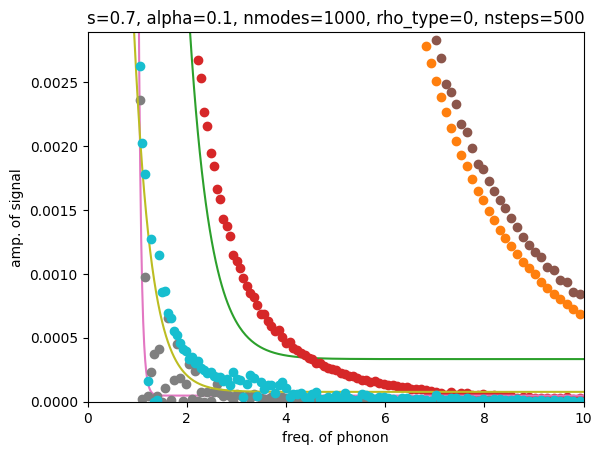

In [86]:
coherent_points_amp_fit_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in coherent_points:
        parms = draw_amp_plot_withfit(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)
        a = parms[0]
        b = parms[1]
        c = parms[2]
        key = line  

        coherent_points_amp_fit_results[key] = (a, b, c)

In [73]:
for key in coherent_points_amp_fit_results:
    value = coherent_points_amp_fit_results[key]
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    print(f's{s:.02f}-alpha{alpha:.02f},', f'{value[0]:.04f},', f'{value[1]:.04f},', f'{value[2]:.04f}')

s0.10-alpha0.05, 5.3885, -1.7682, 0.0075
s0.40-alpha0.05, 0.3157, -2.3302, 0.0003
s0.40-alpha0.10, 2.8744, -1.6512, 0.0068
s0.70-alpha0.05, 638352.1750, -18.5529, 0.0000
s0.70-alpha0.10, 0.0428, -2.8972, 0.0001


In [45]:
incoherent_points_amp_degree_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    key =job_name
    if (s, alpha) in incoherent_points:
        omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key, nstep=nstep)
        dats = [get_signal_amp(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]
    
        buffer = []
        buffer.append([])
        buffer.append([])
        for i in range(dats.__len__()):

            amp_std = np.std(np.array(dats[i][2]))
            amp_mean = np.mean(np.array(dats[i][2]))
            amp_var = np.var(np.array(dats[i][2]))

            degree = amp_var/amp_mean # how fat it is 
            buffer[0].append(amp_var)
            buffer[1].append(degree)
        incoherent_points_amp_degree_results[key] = buffer




In [ ]:
incoherent_points_amp_degree_results

In [52]:
for key in incoherent_points_amp_degree_results:
    value = incoherent_points_amp_degree_results[key]
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    print(f's{s:.02f}-alpha{alpha:.02f},', f'{max(value[0]):.04f},', f'{max(value[1]):.04f}')

s0.70-alpha0.20, 0.0905, 0.2896
s0.70-alpha0.25, 0.0581, 0.1110
s0.70-alpha0.30, 0.0024, 0.0038
s0.70-alpha0.35, 0.0000, 0.0000
s0.70-alpha0.40, 0.0002, 0.0002
s0.70-alpha0.45, 0.0002, 0.0002


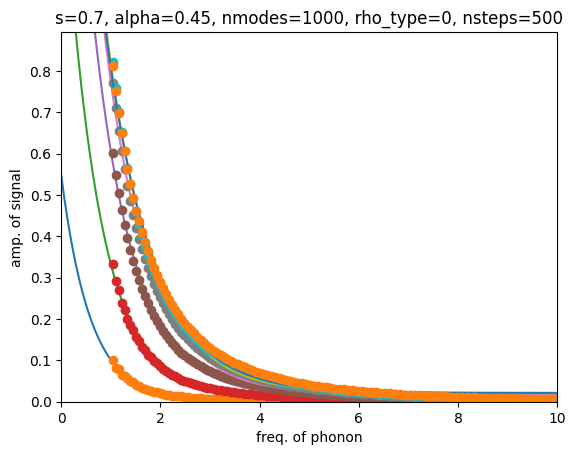

In [85]:
incoherent_points_amp_fit_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in incoherent_points:
        parms = draw_amp_plot_withfit(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)
        a = parms[0]
        b = parms[1]
        c = parms[2]
        key = line  

        incoherent_points_amp_fit_results[key] = (a, b, c)

In [75]:
for key in incoherent_points_amp_fit_results:
    value = incoherent_points_amp_fit_results[key]
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    print(f's{s:.02f}-alpha{alpha:.02f},', f'{value[0]:.04f},', f'{value[1]:.04f},', f'{value[2]:.04f}')

s0.70-alpha0.20, 0.5443, -1.7015, 0.0017
s0.70-alpha0.25, 1.3399, -1.4141, 0.0065
s0.70-alpha0.30, 2.0298, -1.2329, 0.0131
s0.70-alpha0.35, 2.3717, -1.1460, 0.0181
s0.70-alpha0.40, 2.3696, -1.0892, 0.0205
s0.70-alpha0.45, 2.2287, -1.0447, 0.0214


In [65]:
incoherent_points_amp_fit_results

{'traj_s0.70_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.544340855823337,
  -1.7015482083059355,
  0.0017330528222986028),
 'traj_s0.70_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (1.339911986477806,
  -1.4140525457469373,
  0.0065061119657833615),
 'traj_s0.70_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (2.029790305036011,
  -1.2328728785015195,
  0.013130209112787807),
 'traj_s0.70_alpha0.35_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (2.3717062753683926,
  -1.1460205053405033,
  0.018080012326144833),
 'traj_s0.70_alpha0.40_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (2.369638391810113,
  -1.0892149202136232,
  0.0205279461641143),
 'traj_s0.70_alpha0.45_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (2.2287313820267403,
  -1.0446549307396877,
  0.021354745344975497)}

In [ ]:
len(incoherent_points_freq_fit_results) + len(coherent_points_freq_fit_results) + len(pseudo_coherent_points_freq_fit_results)

In [ ]:
sorted(list(incoherent_points_freq_fit_results.keys()) + list(coherent_points_freq_fit_results.keys()) + list(pseudo_coherent_points_freq_fit_results.keys()))

In [ ]:
list(vn_entropy_1site_all_lines.keys())

In [ ]:
draw_freq_plot_withfit(0.1, 0.01, mother_folder, vn_entropy_1site_all_lines, True)

In [ ]:
draw_amp_plot_withfit(0.1, 0.01, mother_folder,vn_entropy_1site_all_lines, True)

In [ ]:
# plt.plot([ _[0] for _ in dats ],[ _[1] for _ in dats ], label ='amp' )

    
# plt.xlabel('freq of ph')
# plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
# plt.ylabel('amp of signal')
# plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
# plt.legend()
# plt.text(x=0.1, y=0.1, s=f'y = {params.x[0]:03f} * x + {params.x[1]:03f}, R**2: {r_2:.3f}')

a = 0.4
b = -1
c = 0.1
y_true = np.array([ _[1] for _ in dats ])
x = np.array([ _[0] for _ in dats ])

def amp_func(x, a, b, c):
    y = a * np.exp(b* x) + c
    return y


def loss(params):
    a, b, c= params
    y_pred = amp_func(x, a, b, c)
    return np.linalg.norm(y_pred - y_true)



params = scipy.optimize.minimize(loss, [a, b, c])
print(params.fun)
a = params.x[0]
b = params.x[1]
c = params.x[2]
r_2 = r_squared(x, y_true, [a, b, c], amp_func)
print(a, b , c)


func_x = np.linspace(0, 10, 500)
func_y = amp_func(func_x, params.x[0], params.x[1], params.x[2])
plt.plot(func_x, func_y , label='fit line')
plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ],'o', label='calc amp')
plt.xlim(0, 10)
plt.xlabel('freq. of phonon')




plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
plt.ylabel('amp. of signal')
plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
plt.legend()
plt.text(x=0.0, y=-0.0, s=f'y = {params.x[0]:.3f} * np.exp({params.x[1]:.3f}* x) + {params.x[2]:3f}, R**2: {r_2:.3f}')


In [ ]:
dats = [get_signal_freq(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]

In [ ]:
def amp_func(x, a, b, c):
    y = a * np.exp(b* x) + c
    return y


def amp_loss(params):
    a, b, c= params
    y_pred = amp_func(x, a, b, c)
    return np.linalg.norm(y_pred - y_true)

def fit_amp_singnal(input_dats):
    
    # preset 
    a = 0.4 
    b = -0.1
    y_true = np.array([ _[1] for _ in input_dats ])
    x = np.array([ _[0] for _ in input_dats ])
    def amp_loss(params):
        a, b, c= params
        y_pred = amp_func(x, a, b, c)
        return np.linalg.norm(y_pred - y_true)
    params = scipy.optimize.minimize(amp_loss, [a, b, c])
# print(params.fun)
    a = params.x[0]
    b = params.x[1]
    c = params.x[2]

    return (a, b, c)




In [ ]:
a = 0.4
b = -0.1

y_true = np.array([ _[1] for _ in dats ])
x = np.array([ _[0] for _ in dats ])

def amp_func(x, a, b, c):
    y = a * np.exp(b* x) + c
    return y


def loss(params):
    a, b, c= params
    y_pred = amp_func(x, a, b, c)
    return np.linalg.norm(y_pred - y_true)



params = scipy.optimize.minimize(loss, [a, b, c])
# print(params.fun)
a = params.x[0]
b = params.x[1]
c = params.x[2]

In [ ]:


y_true = np.array([ _[1] for _ in dats ])
x = np.array([ _[0] for _ in dats ])

def freq_func(x, a, b):
    y = a * x + b 
    return y


def freq_loss(params):
    a, b= params
    y_pred = freq_func(x, a, b)
    return np.linalg.norm(y_pred - y_true)

def fit_freq_singnal(input_dats):
    y_true = np.array([ _[1] for _ in input_dats ])
    x = np.array([ _[0] for _ in input_dats ])
    def freq_loss(params):
        a, b= params
        y_pred = freq_func(x, a, b)
        return np.linalg.norm(y_pred - y_true)
    params = scipy.optimize.minimize(freq_loss, [a, b])
    a = params.x[0]
    b = params.x[1]
    return (a, b)

params = scipy.optimize.minimize(freq_loss, [a, b])
print(params.fun)
a = params.x[0]
b = params.x[1]
r_2 = r_squared(x, y_true, [a, b], freq_func)

In [ ]:
y_true = np.array([ _[1] for _ in dats ])
x = np.array([ _[0] for _ in dats ])
a, b = fit_freq_singnal(dats)
r_2 = r_squared(x, y_true, [a, b], freq_func)

In [ ]:
func_x = np.linspace(0, 10, 500)
func_y = params.x[0] * func_x + params.x[1]
plt.plot(func_x, func_y , label='fit line')
plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ],'o', label='calc freq')
plt.xlim(0, 10)
plt.xlabel('freq. of phonon')
plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
plt.ylabel('freq. of signal')
plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
plt.legend()
plt.text(x=0.1, y=0.1, s=f'y = {params.x[0]:3f} * x + {params.x[1]:3f}, R**2: {r_2:.3f}')

In [ ]:
draw_ids = []
for i in range(11):
    draw_ids.append(ids[i*10])
draw_ids

In [ ]:
mother_folder

In [ ]:
# draw_t_S(pf, vn_entropy_1site_all_lines, key, query_mode=99, nstep=500)
# draw_t_S(pf, vn_entropy_1site_all_lines, key, query_mode=99, nstep=500)
show_result_t_S(mother_folder, vn_entropy_1site_all_lines, s, alpha, query_modes=draw_ids, nstep=500)
plt.xlim(0, 50)

In [ ]:
params

In [ ]:
x

# not need anymore 

In [ ]:
# 

In [ ]:
dats = [get_signal_freq(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=0.7, alpha=0.8, nmodes=1000, rho_type=0, nsteps=100, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]

In [ ]:
plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ])
plt.xlim(0, 10)

In [ ]:
dats = [get_signal_freq(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=0.7, alpha=0.05, nmodes=1000, rho_type=0, nsteps=200, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]

In [ ]:
plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ])
plt.xlim(0, 10)